# CAR DETECTION MODEL
___

## A. DATA PREPARATION
---

In this section, we prepare the dataset for the object detection task using **Roboflow**, a powerful platform that simplifies dataset management, annotation, and preprocessing.

### 📦 Steps Overview

1. **Install the Roboflow module** in the current environment.
2. **Download the dataset** directly from your Roboflow account.
3. **Explore dataset properties** used to train, validate, and test the **Car Retrieval Model**.

### 📁 Dataset Description

For this project, we use the dataset titled [`deteksi-kendaraan-indonesia-3`](https://universe.roboflow.com/deteksikendaraanindonesia3/deteksi-kendaraan-indonesia-3), available publicly on Roboflow Universe.

Prior to usage in this project:

- 🔄 **Preprocessing and augmentation** were performed using Roboflow's built-in tools to enrich the dataset and increase its robustness.
    - Data Preprocessing: 
        1. Auto Orient
        2. Resize 
    - Data Augmentation:
        1. Rotation (between -10 and 10 deg)
        2. Flip Horizontal
        3. Noise (1.01% of pixels)
        4. Brightness (between -15% and 15%)
        5. Blur (up to 2.5 px)
- 🏷️ The original dataset included **four classes**: `bus`, `car`, `motorbike`, and `truck`.
- ✂️ To align with the objectives of this project, the labels were **simplified into two classes**:
  - `car` (combination of `bus`, `car`, and `truck`)
  - `not-car` (within this dataset means `motorbike`)

This tailored dataset better suits our **binary object detection task** for the Car Retrieval Model.

In [1]:
!pip install roboflow

You should consider upgrading via the '/home/st_yudi/personal-github-repository/car-detection-and-classification/venv/bin/python3 -m pip install --upgrade pip' command.


In [2]:
import os
from roboflow import Roboflow
from datetime import datetime
import shutil

# create data directory
data_dirs = "../detection/data"
os.makedirs(data_dirs, exist_ok=True)
log_dirs = "../activity_log"
os.makedirs(log_dirs, exist_ok=True)

# download data from roboflow
rf = Roboflow(api_key="I1XFhPxzTGXbxEZpH4o0")
project = rf.workspace("myworkspace-jewih").project("deteksi-kendaraan-indonesia-3-qiwqr")
dataset = project.version(2).download("yolov5")

# Move dataset to desired path
source_path = dataset.location  # Where Roboflow downloaded it
shutil.move(source_path, os.path.join(data_dirs, os.path.basename(source_path)))
print(f"✅ Dataset moved to: {data_dirs}")

loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to Deteksi-Kendaraan-Indonesia-3-2 in yolov5pytorch:: 100%|██████████| 6070/6070 [00:08<00:00, 733.63it/s] 


✅ Dataset moved to: ../detection/data


## B. EDA
___

In this part I will try to look at the distribution of dataset for training the object detection model, primarily to note the amount of data, label and sneak peek into the sample of image data.

In [4]:
import yaml

# Set path to the dataset
dataset_path = "../detection/data/Deteksi-Kendaraan-Indonesia-3-2"

# train, label, test dataset dir
train_images_dir = os.path.join(dataset_path, "train", "images")
valid_images_dir = os.path.join(dataset_path, "valid", "images")
test_images_dir = os.path.join(dataset_path, "test", "images")

# Read class names from data.yaml
with open(os.path.join(dataset_path, "data.yaml"), 'r') as stream:
    data_yaml = yaml.safe_load(stream)
print("Classes:", data_yaml["names"])

Classes: ['car', 'not-car']


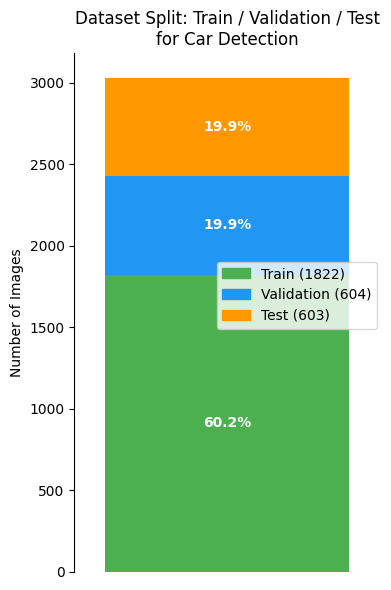

In [5]:
import os
import matplotlib.pyplot as plt

# Count image files
def count_images(path: str) -> int:
    return len([f for f in os.listdir(path) if f.endswith(('.jpg', '.jpeg', '.png'))])

# Get image counts
train_count = count_images(train_images_dir)
valid_count = count_images(valid_images_dir)
test_count = count_images(test_images_dir)

# Data
counts = [train_count, valid_count, test_count]
labels = ['Train', 'Validation', 'Test']
colors = ['#4caf50', '#2196f3', '#ff9800']
total = sum(counts)

# Plot: single vertical stacked bar
fig, ax = plt.subplots(figsize=(4, 6))
bottom = 0

for i in range(len(counts)):
    ax.bar(0, counts[i], bottom=bottom, color=colors[i])
    bottom += counts[i]

# Add percentage text inside each segment
bottom = 0
for i, count in enumerate(counts):
    percentage = (count / total) * 100
    ax.text(0, bottom + count / 2, f"{percentage:.1f}%", ha='center', va='center', color='white', fontsize=10, fontweight='bold')
    bottom += count

# Tweak axes
ax.set_xticks([])
ax.set_xlim(-0.5, 0.5)
ax.set_ylabel("Number of Images")
ax.set_title("Dataset Split: Train / Validation / Test\nfor Car Detection")

# Show y-axis ticks
ax.yaxis.set_visible(True)
ax.spines['left'].set_visible(True)
ax.spines['bottom'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

# Add legend to the right
fig.legend(
    handles=[plt.Rectangle((0, 0), 1, 1, color=c) for c in colors],
    labels=[f"{labels[i]} ({counts[i]})" for i in range(len(counts))],
    loc="center right",
    borderaxespad=1,
    fontsize=10
)

plt.tight_layout()
plt.show()

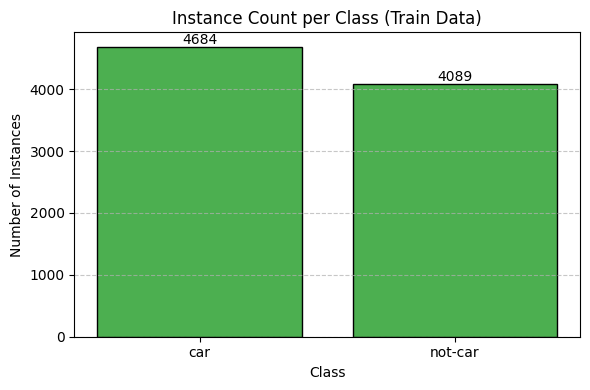

In [6]:
from collections import Counter

train_labels_dir = os.path.join(dataset_path, "train", "labels")
train_label_files = [f for f in os.listdir(train_labels_dir) if f.endswith('.txt')]

# Count instances per class
class_counter = Counter()
for label_file in train_label_files:
    with open(os.path.join(train_labels_dir, label_file), 'r') as f:
        for line in f.readlines():
            class_id = int(line.strip().split()[0])
            class_counter[class_id] += 1

# Map class index to class name
class_names = data_yaml["names"]
class_counts = {class_names[k]: v for k, v in class_counter.items()}

# Prepare data
class_labels = list(class_counts.keys())
counts = list(class_counts.values())

# Plot
plt.figure(figsize=(6, 4))
bars = plt.bar(class_labels, counts, color='#4caf50', edgecolor='black')  # Green color
plt.title("Instance Count per Class (Train Data)")
plt.xlabel("Class")
plt.ylabel("Number of Instances")
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Add value labels on top of bars
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, height + 1, str(height), ha='center', va='bottom')

plt.tight_layout()
plt.show()


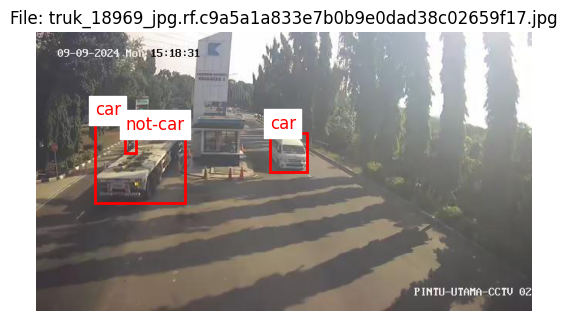

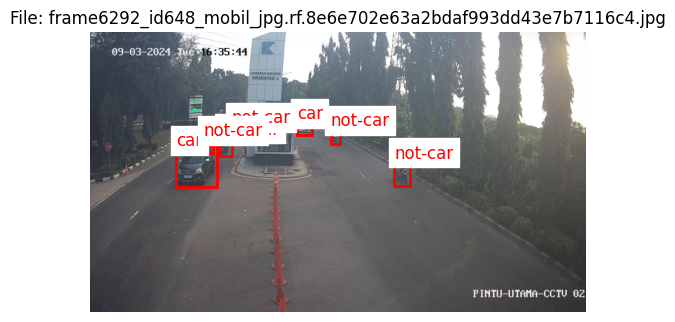

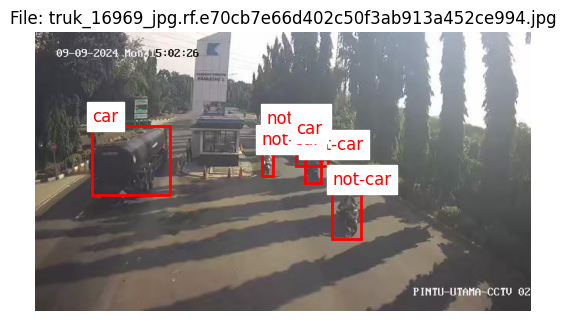

In [7]:
import random
import cv2
import matplotlib.patches as patches

def plot_random_annotated_image():
    train_image_files = [f for f in os.listdir(train_images_dir) if f.endswith('.jpg')]
    file = random.choice(train_image_files)
    image_path = os.path.join(train_images_dir, file)
    label_path = os.path.join(train_labels_dir, file.replace('.jpg', '.txt').replace('.png', '.txt'))

    # Load image
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    h, w, _ = image.shape

    # Load labels
    fig, ax = plt.subplots(1)
    ax.imshow(image)
    
    if os.path.exists(label_path):
        with open(label_path, 'r') as f:
            for line in f.readlines():
                class_id, x_center, y_center, width, height = map(float, line.strip().split())
                # Convert YOLO to box coordinates
                x_min = (x_center - width / 2) * w
                y_min = (y_center - height / 2) * h
                box_width = width * w
                box_height = height * h
                rect = patches.Rectangle((x_min, y_min), box_width, box_height, linewidth=2,
                                         edgecolor='red', facecolor='none')
                ax.add_patch(rect)
                ax.text(x_min, y_min - 5, class_names[int(class_id)], color='red',
                        fontsize=12, backgroundcolor='white')

    plt.title(f"File: {file}")
    plt.axis("off")
    plt.show()

# Show a few examples
for _ in range(3):
    plot_random_annotated_image()

## C. MODEL SELECTION & TRAINING
___
YoloV5 will be used as the object detection model, and use car-vs-not-car dataset from myworspace in roboflow to start with. First I need to clone YoloV5 model from the repository.

In [ ]:
## NEED TO RUN IN GPU ENVIRONMENT
import shutil

# Clone YOLOv5 repo
!git clone https://github.com/ultralytics/yolov5
detection_model_dirs = "../detection/model"
os.makedirs(detection_model_dirs, exist_ok=True)
shutil.move("yolov5", os.path.join(detection_model_dirs, "yolov5"))
print(f"✅ Yolo Model moved to: {detection_model_dirs}")

# install yolov5 requirements
%cd detection/model/yolov5
%pip install -r requirements.txt

In [8]:
# point the data dictionary to absolute path
yaml_content = """
names:
- car
- not-car
nc: 2
roboflow:
  license: CC BY 4.0
  project: deteksi-kendaraan-indonesia-3-qiwqr
  url: https://universe.roboflow.com/myworkspace-jewih/deteksi-kendaraan-indonesia-3-qiwqr/dataset/2
  version: 2
  workspace: myworkspace-jewih
train: ../detection/data/Deteksi-Kendaraan-Indonesia-3-2/train/images
val: ../detection/data/Deteksi-Kendaraan-Indonesia-3-2/valid/images
test: ../detection/data/Deteksi-Kendaraan-Indonesia-3-2/test/images
"""

with open('../detection/data/Deteksi-Kendaraan-Indonesia-3-2/data.yaml', 'w') as f:
    f.write(yaml_content.strip())

In [ ]:
## NEED TO BE RUN IN GPU ENVIRONMENT

from datetime import datetime

# Generate timestamp
timestamp = datetime.now().strftime("%Y%m%d%H%M%S")
train_log_path = f"/kaggle/working/activity_log/{timestamp}-CarDetectionTrain.log"

!python ../detection/model/yolov5/train.py \
  --img 640 \
  --batch 16 \
  --epochs 50 \
  --data ../detection/data/data.yaml \
  --weights yolov5s.pt \
  --project detection \
  --name car-detector \
  --exist-ok \
2>&1 | tee {train_log_path}

print(f"Training Log Saved In {train_log_path}")

In [7]:
import re
from typing import List, Dict

def parse_train_log(log_path: str) -> List[Dict[str, float]]:
    """Function to parse YoloV5 Training log
    Args:
        log_path (str):
            log path of the trainig log
    Returns:
        List[Dict[str, float]]:
            training data for visualization
    """
    # Updated regex to also capture batch number from the end
    pattern = re.compile(
        r"(\d+)/(\d+)\s+\S+\s+([\d.]+)\s+([\d.]+)\s+([\d.]+).*?\s(\d+)/(\d+)"
    )

    parsed_data = []

    with open(log_path, "r") as file:
        for line in file:
            match = pattern.search(line)
            if match:
                epoch = int(match.group(1))
                # match.group(2) = total epochs, not used
                box_loss = float(match.group(3))
                obj_loss = float(match.group(4))
                cls_loss = float(match.group(5))
                batch = int(match.group(6))
                # match.group(7) = total batches, not used

                parsed_data.append({
                    "epoch": epoch,
                    "batch": batch,
                    "box_loss": box_loss,
                    "obj_loss": obj_loss,
                    "cls_loss": cls_loss
                })

    return parsed_data

def parse_valid_log(log_path: str) -> List[Dict[str, float]]:
    """Function to parse validation log
    Args:
        log_path (str):
            path to parse validation log
    Returns:
        List[Dict[str, float]]:
            validation data from training yolov5
    """
    val_metrics = []
    
    with open(log_path, "r") as file:
        lines = file.readlines()
        for i, line in enumerate(lines):
            if line.strip().startswith("all"):
                parts = line.split()
                if len(parts) >= 7:
                    val_metrics.append({
                        "images": int(parts[1]),
                        "instances": int(parts[2]),
                        "precision": float(parts[3]),
                        "recall": float(parts[4]),
                        "mAP50": float(parts[5]),
                        "mAP50_95": float(parts[6])
                    })

    return val_metrics

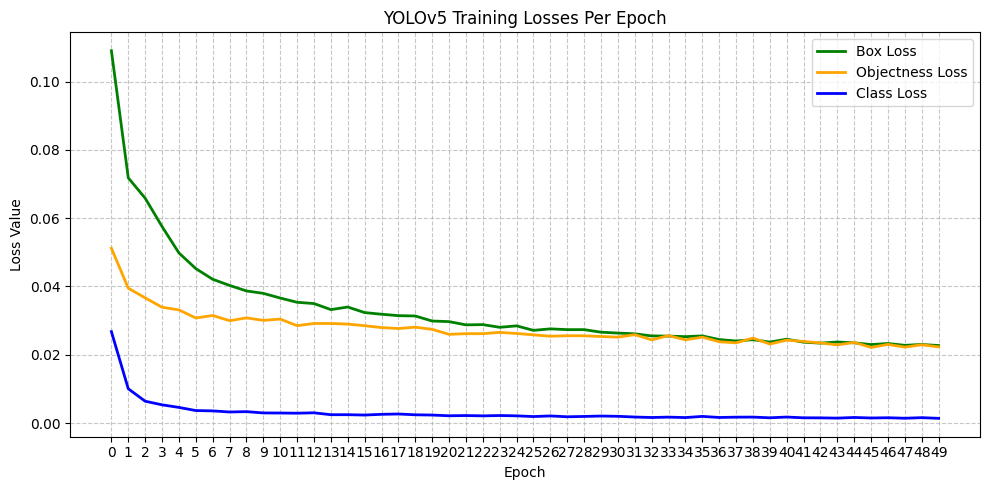

In [8]:
import pandas as pd

log_path = "../activity_log/20250624195300-CarDetectionTrain.log"
train_log_data = parse_train_log(log_path)

# Convert to DataFrame
df = pd.DataFrame(train_log_data)

# Group by epoch to get average per epoch
epoch_group = df.groupby('epoch').mean(numeric_only=True).reset_index()

# Plot
plt.figure(figsize=(10, 5))
plt.plot(epoch_group['epoch'], epoch_group['box_loss'], label='Box Loss', color='green', linewidth=2)
plt.plot(epoch_group['epoch'], epoch_group['obj_loss'], label='Objectness Loss', color='orange', linewidth=2)
plt.plot(epoch_group['epoch'], epoch_group['cls_loss'], label='Class Loss', color='blue', linewidth=2)

# Styling
plt.title("YOLOv5 Training Losses Per Epoch")
plt.xlabel("Epoch")
plt.ylabel("Loss Value")
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)
plt.xticks(epoch_group['epoch'])  # Show integer epoch ticks
plt.gca().set_facecolor('white')  # Remove gray background

plt.tight_layout()
plt.show()

### 📊 Training Loss Curve Analysis (YOLOv5)

#### 🧠 Objective
This graph illustrates how the YOLOv5 model's training losses evolve over **50 epochs**, helping us assess the learning stability and convergence of the model.

---

#### ✅ Key Observations

##### 📦 Box Loss (Green Line)
- **Meaning**: Measures error in predicting bounding box coordinates.
- **Trend**: Sharp decline in early epochs, followed by gradual stabilization.
- **Interpretation**: The model quickly learned to localize objects within the first 10–15 epochs.

##### 🎯 Objectness Loss (Orange Line)
- **Meaning**: Reflects model confidence in object presence (vs. background).
- **Trend**: Steady decline, stabilizing around epoch 30.
- **Interpretation**: The model progressively improved at recognizing when an object is present.

##### 🏷️ Class Loss (Blue Line)
- **Meaning**: Measures classification errors on detected objects.
- **Trend**: Starts low and approaches zero quickly.
- **Interpretation**: The model learned the object classes effectively from early epochs.

---

#### 📌 Conclusion
- The model **converged successfully**, with all loss components reducing over time.
- No clear signs of **overfitting** are observed from the training loss alone.


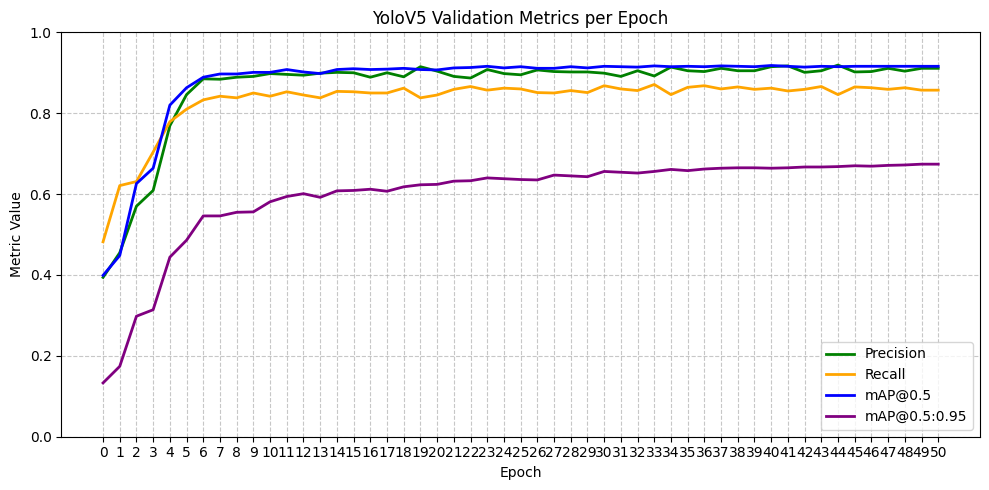

In [12]:
log_path = "../activity_log/20250624195300-CarDetectionTrain.log"
val_metrics = parse_valid_log(log_path)

# Convert to DataFrame
val_df = pd.DataFrame(val_metrics)
val_df.index.name = 'epoch'
val_df.reset_index(inplace=True)

# Plot
plt.figure(figsize=(10, 5))
plt.plot(val_df['epoch'], val_df['precision'], label='Precision', color='green', linewidth=2)
plt.plot(val_df['epoch'], val_df['recall'], label='Recall', color='orange', linewidth=2)
plt.plot(val_df['epoch'], val_df['mAP50'], label='mAP@0.5', color='blue', linewidth=2)
plt.plot(val_df['epoch'], val_df['mAP50_95'], label='mAP@0.5:0.95', color='purple', linewidth=2)

# Styling
plt.title("YoloV5 Validation Metrics per Epoch")
plt.xlabel("Epoch")
plt.ylabel("Metric Value")
plt.ylim(0, 1)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)
plt.xticks(val_df['epoch'])
plt.gca().set_facecolor('white')

plt.tight_layout()
plt.show()


### 🧪 Validation Metrics per Epoch (YOLOv5)

#### 🎯 Purpose
This chart visualizes how the model's performance on the **validation set** improves across 50 epochs using the following key metrics:
- **Precision**
- **Recall**
- **mAP@0.5**
- **mAP@0.5:0.95**

---

#### ✅ Key Observations

##### ✅ Precision (Green Line)
- **Definition**: The proportion of predicted positives that are true positives.
- **Insight**: Precision rose rapidly within the first 5–7 epochs and stabilized above **0.88**, indicating the model reliably avoids false positives.

##### 🔁 Recall (Orange Line)
- **Definition**: The proportion of true positives that were correctly predicted.
- **Insight**: Followed a similar trend to precision, stabilizing around **0.85–0.88**. This shows the model is successfully detecting most relevant objects.

##### 🎯 mAP@0.5 (Blue Line)
- **Definition**: Mean Average Precision using an IoU threshold of 0.5.
- **Insight**: Peaked quickly (~0.91) and remained stable — a strong indicator of high-quality detection with loose localization tolerance.

##### 🎯 mAP@0.5:0.95 (Purple Line)
- **Definition**: A stricter average precision measure across IoU thresholds [0.5:0.95].
- **Insight**: Grew steadily, plateauing near **0.67** — a healthy indicator of robustness under tighter localization demands.

---

#### 📌 Summary
- All validation metrics show rapid improvement early in training and converge smoothly.
- The high and stable **precision**, **recall**, and **mAP** values confirm that:
  - The model is **accurate**, **robust**, and **generalizes well** to unseen data.
  - There are **no signs of overfitting**, as validation performance continues to improve or remains stable throughout.

---

> 🔍 Next Steps: For deployment, consider post-processing or confidence threshold tuning to balance precision and recall per business needs.


<img src="../detection/images/confusion_matrix.png">

### 📉 Confusion Matrix Analysis (YOLOv5 Classification)

#### 🧠 Objective
This confusion matrix visualizes the classification performance of the YOLOv5 model across three categories: **car**, **not-car**, and **background**. It helps assess how accurately the model distinguishes between these classes during testing.

---

#### ✅ Key Observations

##### 🚗 **True Label: `car`**
- **94%** of `car` objects were correctly predicted as `car`.
- **1%** were misclassified as `not-car`.
- **5%** were incorrectly labeled as `background`.
- ✅ **Interpretation**: The model performs **very well** at detecting cars.

##### 🛵 **True Label: `not-car`**
- **85%** of `not-car` objects were correctly predicted.
- **15%** were misclassified as `background`.
- 🔍 **Interpretation**: Good performance, but with some tendency to miss objects and consider them background.

##### 🪧 **True Label: `background`**
- **65%** of the background regions were incorrectly predicted as `not-car`.
- Only **35%** of the background was correctly ignored.
- ⚠️ **Interpretation**: The model is **overpredicting** `not-car` on the background, leading to false positives.

---

#### 📌 Conclusion
- The model performs **best** at identifying `car` objects with high confidence.
- There’s **room for improvement** in distinguishing `not-car` vs `background`.
- Potential action: Introduce **more diverse background samples** during training to reduce false positives.


<img src="../detection/images/F1_curve.png">

### 📈 F1-Confidence Curve Analysis

#### 🧠 Objective
This curve illustrates the relationship between **prediction confidence** and the **F1-score** for each class (`car`, `not-car`) during evaluation. It helps determine the **optimal confidence threshold** to maximize model performance.

---

#### ✅ Key Observations

##### 📦 All Classes (Bold Blue Line)
- **Peak F1-score**: **0.88** achieved at a confidence threshold of **0.467**.
- ✅ **Interpretation**: This is the **recommended threshold** for balancing precision and recall across all classes.

##### 🚗 Car Class (Light Blue Line)
- **Consistently high F1-score** across all thresholds, peaking close to **0.92**.
- ✅ **Interpretation**: The model is very confident and accurate in predicting `car` objects.

##### 🛵 Not-Car Class (Orange Line)
- **Lower overall F1-score**, peaking below **0.85**.
- 📉 **Interpretation**: Model is less confident and more prone to errors for `not-car` objects, possibly due to:
  - Class imbalance
  - Higher visual variation
  - Ambiguous labeling

---

#### 📌 Conclusion
- The **optimal threshold** of `0.467` can be used to fine-tune the model for deployment.
- The model is **more reliable for detecting cars** than other vehicles or objects (`not-car`).
- Consider **rebalancing the dataset** or adding **hard examples** to improve `not-car` classification.


<img src="../detection/images/P_curve.png">

### 🎯 Precision-Confidence Curve Analysis

#### 🧠 Objective
This graph shows how **precision** changes with respect to **confidence threshold** for each class (`car`, `not-car`). It helps determine the threshold at which the model achieves **maximum precision** — i.e., the fewest false positives.

---

#### ✅ Key Observations

##### 📦 All Classes (Bold Blue Line)
- **Peak precision**: **1.00** (100%) at a confidence threshold of **0.988**.
- ✅ **Interpretation**: The model makes **perfectly precise predictions** when it's very confident (≥ 0.988), though likely at the cost of lower recall.

##### 🚗 Car Class (Light Blue Line)
- Precision starts high and stays consistently strong across all thresholds.
- ✅ **Interpretation**: The model is highly accurate at identifying cars, even at lower confidence levels.

##### 🛵 Not-Car Class (Orange Line)
- Precision improves as the confidence threshold increases but remains **below car class** throughout.
- 📉 **Interpretation**: There are more false positives in the `not-car` category, indicating the model finds it harder to distinguish these reliably.

---

#### 📌 Conclusion
- To **maximize model reliability** and minimize false detections, a high confidence threshold (e.g., **0.988**) should be used if **precision is prioritized**.
- For a balanced trade-off between precision and recall, combine this with the F1-Confidence Curve to select a more suitable threshold (e.g., ~0.467 from the F1 graph).
- Suggest adding more diverse `not-car` examples to improve class separation and reduce misclassification.


<img src="../detection/images/R_curve.png">

### 🔁 Recall-Confidence Curve Analysis

#### 🧠 Objective
This graph illustrates how **recall** varies with the **confidence threshold** for each class (`car`, `not-car`). It shows how well the model detects **all true positives**, especially at different certainty levels.

---

#### ✅ Key Observations

##### 📦 All Classes (Bold Blue Line)
- **Peak recall**: **0.96 (96%)** at **confidence threshold = 0.0**.
- ⚠️ **Interpretation**: At very low confidence, the model detects nearly all true positives (high recall) but likely includes more false positives — hence lower precision.

##### 🚗 Car Class (Light Blue Line)
- Recall remains consistently high and only declines sharply near confidence = 1.0.
- ✅ **Interpretation**: The model is very sensitive to the presence of cars and tends to detect them successfully, even at higher thresholds.

##### 🛵 Not-Car Class (Orange Line)
- Recall is **lower and more sensitive** to confidence changes compared to `car`.
- 📉 **Interpretation**: The model misses more `not-car` objects as the threshold increases, indicating it struggles more with this class.

---

#### 📌 Conclusion
- To **maximize recall**, a **lower threshold** (e.g., ~0.0 to 0.2) is ideal, especially for detecting **all possible true objects**.
- However, this should be balanced with **precision** (from the previous curve), as high recall at low thresholds often comes with more false positives.
- For a real-world deployment, select a threshold based on **F1-score** to balance both.

<img src="../detection/images/PR_curve.png">

### 🔄 Precision-Recall (PR) Curve Analysis

#### 🧠 Objective
The PR curve shows the trade-off between **precision** and **recall** across thresholds. It's especially useful for **imbalanced datasets** like yours (e.g., `car` vs `not-car`).

---

#### 📈 Key Metrics (From Legend)
| Class     | AP (Average Precision) |
|-----------|------------------------|
| `car`     | **0.962**              |
| `not-car` | **0.869**              |
| **All**   | **0.916** mAP@0.5      |

- 📌 `mAP@0.5` refers to **mean Average Precision** with IoU threshold = 0.5, a standard metric in object detection.

---

#### 🟦 All Classes (Bold Blue Line)
- Very high performance overall.
- Precision stays near **1.0** for most of the recall range.
- Slight drop at high recall levels, as expected.

✅ **Interpretation**: The model balances precision and recall well, indicating reliable detections without many false positives or false negatives.

---

#### 🚗 Car Class (Light Blue Line)
- Highest performance of both classes (AP = 0.962).
- Precision remains extremely high across nearly all recall values.
- Sharp decline only near perfect recall.

✅ **Interpretation**: The model **almost always detects cars accurately**, making it highly reliable for car classification.

---

#### 🛵 Not-Car Class (Orange Line)
- Lower but still strong performance (AP = 0.869).
- Precision drops more quickly as recall increases, indicating more false positives at higher recall.

📉 **Interpretation**: The model finds it harder to distinguish `not-car` objects without sacrificing precision.

---

#### 🧠 Conclusion
- With a **mean AP of 0.916**, your model is **highly performant** overall.
- It's better at detecting `car` than `not-car`, which is typical when class imbalance or subtle features affect classification.
- Thresholds can be fine-tuned to prioritize either **precision** (for fewer false alarms) or **recall** (for fewer missed detections).

## D. MODEL EVALUATION
___

In [ ]:
## THIS NEED TO BE RUN IN GPU ENVIRONMENT
from datetime import datetime

# Generate timestamp
timestamp = datetime.now().strftime("%Y%m%d%H%M%S")
test_log_path = f"../activity_log/{timestamp}-CarDetectionTest.log"

!python ../detection/model/yolov5/val.py \
  --img 416 \
  --batch 16 \
  --data ../detection/data/data.yaml \
  --weights ../detection/model/yolov5/car-detector/weights/best.pt \
  --task test \
2>&1 | tee {test_log_path}

print(f"Test Log Saved In {test_log_path}")

In [13]:
import re
from typing import Dict

def parse_yolo_test_log(log_text: str) -> Dict[str, Dict[str, float]]:
    """
     YOLOv5 test log text and extracts metrics per class.
    Parameters:
        log_text (str): Full text of the YOLOv5 test log.
    Returns:
        Dict[str, Dict[str, float]]: A dictionary with class names as keys and their metrics as values.
    """
    metrics = {}
    
    # Regex pattern to capture rows like:
    # class_name   images   instances   precision   recall   mAP@50   mAP@50-95
    pattern = re.compile(
        r'^\s*(\S.*?)\s{2,}[\d,]+\s+[\d,]+\s+([0-9.]+)\s+([0-9.]+)\s+([0-9.]+)\s+([0-9.]+)',
        re.MULTILINE
    )

    for match in pattern.finditer(log_text):
        class_name = match.group(1).strip()
        precision = float(match.group(2))
        recall = float(match.group(3))
        map_50 = float(match.group(4))
        map_50_95 = float(match.group(5))

        metrics[class_name] = {
            'Precision': precision,
            'Recall': recall,
            'mAP@0.5': map_50,
            'mAP@0.5:0.95': map_50_95
        }

    return metrics


In [14]:
with open('../activity_log/20250624195300-CarDetectionTest.log', 'r') as f:
    log_text = f.read()

results = parse_yolo_test_log(log_text)

# Print nicely
for label, values in results.items():
    print(f"\n📦 {label}")
    for metric, value in values.items():
        print(f"{metric:<15}: {value:.3f}")


📦 all
Precision      : 0.894
Recall         : 0.862
mAP@0.5        : 0.912
mAP@0.5:0.95   : 0.670

📦 car
Precision      : 0.934
Recall         : 0.931
mAP@0.5        : 0.967
mAP@0.5:0.95   : 0.777

📦 not-car
Precision      : 0.853
Recall         : 0.793
mAP@0.5        : 0.857
mAP@0.5:0.95   : 0.562


### 📊 Test Evaluation Summary (YOLOv5)

#### 🧠 Objective
This summary evaluates the model’s detection performance using standard metrics like **Precision**, **Recall**, and **mAP** on a test set of 603 images. The results are provided for each class (`car`, `not-car`) and overall (`all`).

---

#### ✅ Key Observations

##### 📦 `all` (Overall Performance)
- **Precision**: `0.894` — The model correctly predicted 89.4% of detected objects.
- **Recall**: `0.862` — It captured 86.2% of all ground-truth objects.
- **mAP@0.5**: `0.912` — Strong localization performance at IoU 0.5.
- **mAP@0.5:0.95**: `0.670` — Indicates good performance across stricter IoU thresholds.

> 📌 **Interpretation**: The model performs well in both detection and localization across all classes.

---

##### 🚗 `car` Class
- **Precision**: `0.934` — Very few false positives.
- **Recall**: `0.931` — Nearly all true `car` instances were detected.
- **mAP@0.5**: `0.967` — Excellent bounding box alignment.
- **mAP@0.5:0.95**: `0.777` — High robustness under varying IoU thresholds.

> ✅ **Interpretation**: `car` class detection is highly reliable and consistent, with strong precision and recall balance.

---

##### 🚫 `not-car` Class
- **Precision**: `0.853` — Fair accuracy, though more false positives than for `car`.
- **Recall**: `0.793` — Some missed detections for `not-car` instances.
- **mAP@0.5**: `0.857` — Good bounding box accuracy.
- **mAP@0.5:0.95**: `0.562` — Weaker performance under strict IoU conditions.

> ⚠️ **Interpretation**: `not-car` class performance is lower, suggesting potential data imbalance or difficulty in class definition.

---

#### 📌 Conclusion
- The model shows **excellent performance** for the `car` class, while **`not-car` detection needs improvement**.
- Overall, the high `mAP@0.5` values indicate solid localization ability.
- The gap between `mAP@0.5` and `mAP@0.5:0.95` suggests room for improvement in tighter box predictions, especially for `not-car`.

## E. MODEL INFERENCE
___

In [ ]:
# NEED TO BE RUN IN GPU ENVIRONMENT
from datetime import datetime

# Generate timestamp
timestamp = datetime.now().strftime("%Y%m%d%H%M%S")
inference_log_path = f"../activity_log/{timestamp}-CarDetectionInference.log"

!python ../detection/model/yolov5/detect.py \
  --weights ../detection/model/artifact/best.pt \
  --source ../video_test/traffic_test.mp4 \
  --img 640 \
  --conf 0.25 \
  --project detection \
  --name traffic_test_inference \
  --exist-ok \
2>&1 | tee {inference_log_path}

<img src="../detection/result/images/car-detection-img-000.png" width="30%"> <img src="../detection/result/images/car-detection-img-001.png" width="30%"> <img src="../detection/result/images/car-detection-img-002.png" width="30%">
<img src="../detection/result/images/car-detection-img-003.png" width="30%"> <img src="../detection/result/images/car-detection-img-004.png" width="30%"> <img src="../detection/result/images/car-detection-img-005.png" width="30%">

### 🚗 Car Detection Demo (YOLOv5)

#### 🧠 Objective
This slide showcases the real-world performance of our YOLOv5 model in detecting and classifying objects into two categories: `car` and `not-car`, using test images from urban traffic scenes.

---

#### ✅ Key Highlights

- **Two-class Detection**: The model distinguishes between `car` (highlighted in blue) and `not-car` (e.g., motorbikes, bicycles, pedestrians — highlighted in cyan).
- **Confidence Scores**: Each bounding box is accompanied by a class label and its associated confidence score (ranging from 0.41 to 0.96 in the samples shown).
- **Dense Traffic Handling**: Despite heavy and overlapping traffic conditions, the model correctly identifies most vehicles with high confidence, particularly for the `car` class.
- **Diverse Scenarios**: The samples demonstrate detection under varied orientations, partial occlusions, and different lighting/contrast conditions, simulating real-world deployment.

---

#### 📌 Observations

- ✅ **`car` Class**:
  - Consistently high confidence (often > 0.9) across multiple angles and types of cars.
  - Even partially occluded cars are detected (e.g., rear or side views).
  
- ⚠️ **`not-car` Class**:
  - Detects scooters, bikes, and riders fairly well, but with slightly more variation in confidence (ranging from 0.52 to 0.88).
  - Some potential false positives or lower confidence may occur due to visual similarity or occlusion.

---

#### 🏁 Conclusion
- The model demonstrates **robust and practical object detection capabilities** in real urban traffic environments.
- Especially effective for `car` identification, while `not-car` detection can still benefit from further tuning or data enrichment.



# CAR CLASSIFICATION MODEL
___

## A. DATA PREPARATION
___

### 📥 Step 1: Data Collection with crawl.py
The dataset is collected using a Python script called crawl.py, which utilizes Bing Image Crawler to download images based on specific search keywords in Bahasa Indonesia. The script uses the following keyword-label configuration:
```
    car_categories = [
        {"label": "bajaj", "keywords": "Gambar Bajaj di Indonesia", "num_images": 200},
        {"label": "double_cabin", "keywords": "Gambar Mobil double cabin di Indonesia", "num_images": 200},
        {"label": "jeep", "keywords": "Gambar Mobil jeep di Indonesia", "num_images": 200},
        {"label": "bus", "keywords": "Gambar Mobil Bus di Indonesia", "num_images": 200},
        {"label": "hatchback", "keywords": "Gambar Mobil Hatchback di Indonesia", "num_images": 200},
        {"label": "minivan", "keywords": "Gambar Mobil minivan di Indonesia", "num_images": 200},
        {"label": "mpv", "keywords": "Gambar Mobil MPV di Indonesia", "num_images": 200},
        {"label": "pickup", "keywords": "Gambar Mobil Pickup di Indonesia", "num_images": 200},
        {"label": "sedan", "keywords": "Gambar Mobil Sedan di Indonesia", "num_images": 200},
        {"label": "suv", "keywords": "Gambar Mobil SUV di Indonesia", "num_images": 200},
        {"label": "truck", "keywords": "Gambar Mobil Truck di Indonesia", "num_images": 200},
    ]
```
Each keyword search will download up to 200 images and store them in a folder structure under the raw/ directory. The folder name corresponds to the car type label.
This project includes 11 car categories:
    
        1. bajaj
        2. bus
        3. double_cabin
        4. hatchback
        5. jeep
        6. minivan
        7. mpv
        8. pickup
        9. sedan
        10. suv
        11. truck  

### 🧹 Step 2: Auto-cropping with Pre-trained YOLO
Once the raw data is downloaded, a pre-trained YOLO model is used to:
- Detect vehicles in the images.
- Automatically crop the detected vehicles.
The cropped images are then stored in classification/data/crop directory for further processing.

### 🕵️ Step 3: Manual Curation
After auto-cropping, a manual curation process is performed to ensure:
- Image quality
- Label consistency
Removal of incorrect or irrelevant data

### 🧪 Step 4: Data Preprocessing
After the auto-cropping and manual curation process, the dataset is prepared for training by performing the following steps:
- Data Splitting:
The cropped images are split into three subsets:
    - Training set
    - Validation set
    - Test set
This ensures proper model evaluation and generalization.

- Data Augmentation:
To address class imbalance and increase the diversity of the training data, various augmentation techniques (e.g., flipping, rotation, brightness adjustment) are applied only to the training set. 

This preprocessing step ensures that the model is trained on a more balanced and representative dataset, improving its ability to generalize across different car types.

First I will try to look at the distribution of raw images

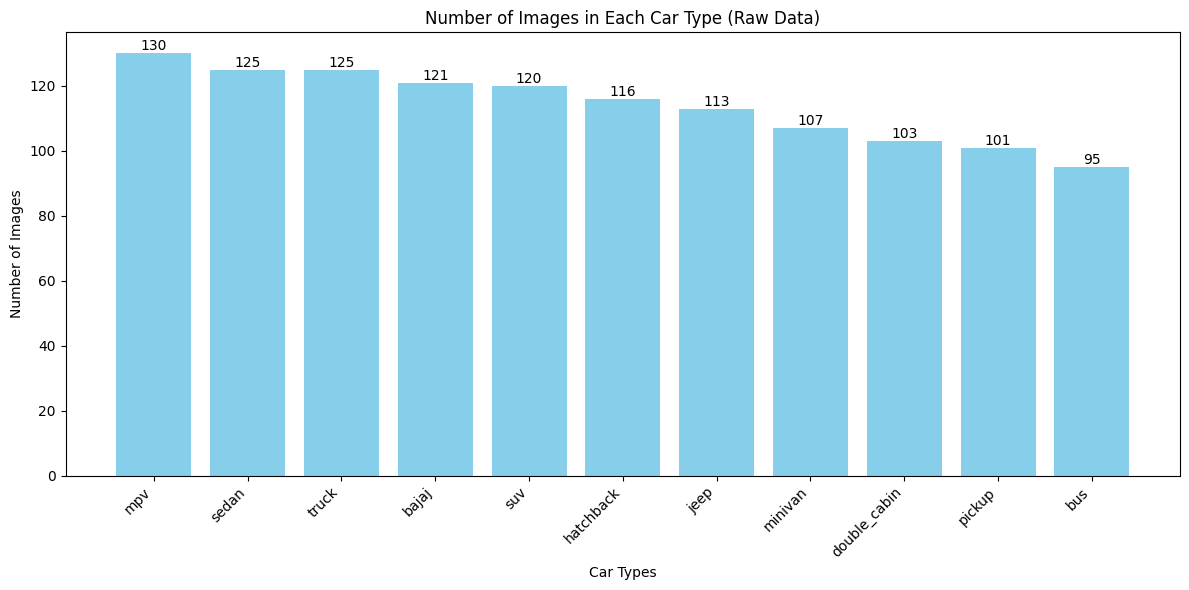

In [16]:
# Script to plot distributed data of raw images
import os
import matplotlib.pyplot as plt

car_type = ['bajaj', 'bus', 'double_cabin', 'hatchback', 'jeep', 'minivan', 'mpv', 'pickup', 'sedan', 'suv', 'truck']
raw_dir = "../classification/data/raw"

# Count items in each folder
image_counts = {}
for car in car_type:
    folder_path = os.path.join(raw_dir, car)
    if os.path.exists(folder_path) and os.path.isdir(folder_path):
        count = len(os.listdir(folder_path))
        image_counts[car] = count
    else:
        print(f"Warning: Folder '{car}' not found or is not a directory")
        image_counts[car] = 0  # Assign 0 if folder doesn't exist

# Sort folders by count (descending) for better visualization
sorted_folders = sorted(image_counts.items(), key=lambda x: x[1], reverse=True)
folders_sorted = [item[0] for item in sorted_folders]
counts_sorted = [item[1] for item in sorted_folders]

# Create the plot
plt.figure(figsize=(12, 6))
bars = plt.bar(folders_sorted, counts_sorted, color='skyblue')

# Add value labels on top of each bar
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
             f'{int(height)}',
             ha='center', va='bottom')

plt.xlabel('Car Types')
plt.ylabel('Number of Images')
plt.title('Number of Images in Each Car Type (Raw Data)')
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better readability
plt.tight_layout()  # Adjust layout to prevent label cutoff

# Show the plot
plt.show()

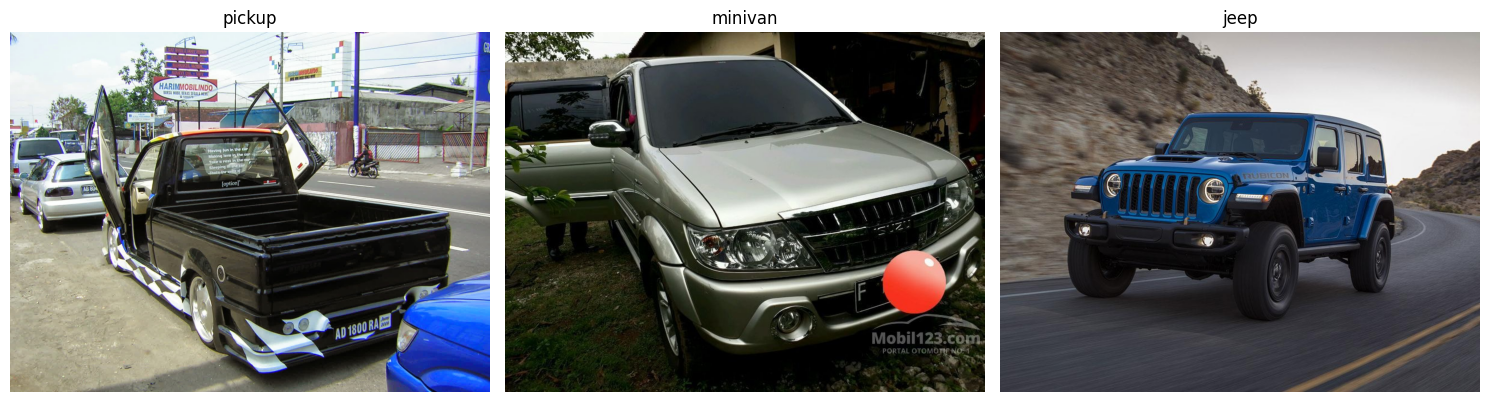

In [17]:
import os
import random
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Car type folders
car_type = ['bajaj', 'bus', 'double_cabin', 'hatchback', 'jeep', 'minivan', 'mpv', 'pickup', 'sedan', 'suv', 'truck']
raw_dir = "../classification/data/raw"

# Collect valid image paths
all_images = []
for car in car_type:
    folder_path = os.path.join(raw_dir, car)
    if os.path.exists(folder_path) and os.path.isdir(folder_path):
        images = os.listdir(folder_path)
        images = [img for img in images if img.lower().endswith((".jpg", ".jpeg", ".png"))]
        for img in images:
            all_images.append((car, os.path.join(folder_path, img)))

# Sample 3 random images
sampled_images = random.sample(all_images, min(3, len(all_images)))

# Plot the images
plt.figure(figsize=(15, 5))
for i, (car_type, path) in enumerate(sampled_images):
    img = mpimg.imread(path)
    plt.subplot(1, 3, i + 1)
    plt.imshow(img)
    plt.axis('off')
    plt.title(f"{car_type}")

plt.tight_layout()
plt.show()

## C. DATA PREPROCESSING
___
Data Preprocessing will be consisting about cropping the data into intended car section in an images, manual inspection to the cropped data, spliting data into train, validation, and test, and last but not least augmenting train data to balanced the class distribution. This section will crop the raw data images in directory `classifiction/data/raw` and pass the cropped image into directory `classification/data/crop`. After this process is being done, then manual check need to be performed to the cropped data.

In [19]:
## NEED TO BE RUN IN GPU ENVIRONMENT

## Crop the images using pre-trained YoloV5
import os
from pathlib import Path
from PIL import Image
import torch
from tqdm import tqdm

# Load pretrained YoloV5
crop_model = torch.hub.load('../detection/model/yolov5/','custom',
                            path='../detection/model/artifact/best.pt',
                            source='local')
source_image_dir = Path("../classification/data/raw")
target_image_dir = Path("../classification/data/crop")
target_image_dir.mkdir(parents=True, exist_ok=True)

# Loop in source dir folders
for car_folder in tqdm(sorted(source_image_dir.iterdir())):
    if car_folder.is_dir():
        label = car_folder.name
        target_label_folder = target_image_dir / label
        target_label_folder.mkdir(parents=True, exist_ok=True)

        # Loop through images
        for img_file in sorted(car_folder.glob("*.*")):
            try:
                results = crop_model(str(img_file))
                for i, (*xyxy, conf, cls) in enumerate(results.xyxy[0]):
                    img = Image.open(img_file).convert("RGB")
                    x1, y1, x2, y2 = map(int, xyxy)
                    cropped = img.crop((x1, y1, x2, y2))
                    new_filename = f"{img_file.stem}_crop{i}.jpg"
                    cropped.save(target_label_folder / new_filename)
            except Exception as e:
                print(f"Error processing {img_file}: {e}")

pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
YOLOv5 🚀 v7.0-421-g79c4c31d Python-3.9.12 torch-2.7.1+cu126 CPU

Fusing layers... 
Model summary: 157 layers, 7015519 parameters, 0 gradients, 15.8 GFLOPs
Adding AutoShape... 
  0%|          | 0/11 [00:00<?, ?it/s]`torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
`torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
`torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
`torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
`torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
`torch.cuda.amp.a

This section will split already curated cropped data into train, validation, and test data. Along with it augmentation on train data will be performed to maintain proper balance within the class distribution.

In [9]:
import os
import random
import shutil
import cv2
import numpy as np
import albumentations as A
from matplotlib import pyplot as plt
from collections import defaultdict
from tqdm import tqdm

# Configuration
INPUT_DIR = "../classification/data/crop"
OUTPUT_DIR = "../classification/data/preprocess_data"
TRAIN_RATIO = 0.7
VAL_RATIO = 0.15
TEST_RATIO = 0.15
SEED = 42  # For reproducibility

def create_directory_structure():
    """Create the directory structure for split data"""
    os.makedirs(os.path.join(OUTPUT_DIR, "train"), exist_ok=True)
    os.makedirs(os.path.join(OUTPUT_DIR, "val"), exist_ok=True)
    os.makedirs(os.path.join(OUTPUT_DIR, "test"), exist_ok=True)
    os.makedirs(os.path.join(OUTPUT_DIR, "augmented_train"), exist_ok=True)

def split_dataset():
    """Split dataset into train/val/test sets"""
    random.seed(SEED)
    
    for class_name in tqdm(os.listdir(INPUT_DIR), desc="Splitting classes"):
        class_path = os.path.join(INPUT_DIR, class_name)
        if not os.path.isdir(class_path):
            continue
            
        # Get all image files
        images = [f for f in os.listdir(class_path) 
                if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
        random.shuffle(images)
        
        # Calculate split indices
        total = len(images)
        train_end = int(TRAIN_RATIO * total)
        val_end = train_end + int(VAL_RATIO * total)
        
        # Create class directories in each split
        for split in ["train", "val", "test"]:
            os.makedirs(os.path.join(OUTPUT_DIR, split, class_name), exist_ok=True)
        
        # Copy images to respective directories
        for i, img_name in enumerate(images):
            src = os.path.join(class_path, img_name)
            
            if i < train_end:
                dst = os.path.join(OUTPUT_DIR, "train", class_name, img_name)
            elif i < val_end:
                dst = os.path.join(OUTPUT_DIR, "val", class_name, img_name)
            else:
                dst = os.path.join(OUTPUT_DIR, "test", class_name, img_name)
            
            shutil.copy2(src, dst)

def get_augmentation_pipelines():
    """Return different augmentation pipelines for variety"""
    return [
        # Mild geometric transformations
        A.Compose([
            A.HorizontalFlip(p=0.5),
            A.Rotate(limit=15, p=0.7),
            A.Blur(blur_limit=(0, 3), p=0.3)
        ]),
        
        # Color transformations
        A.Compose([
            A.HueSaturationValue(hue_shift_limit=20, sat_shift_limit=20, val_shift_limit=20, p=0.7),
            A.RandomBrightnessContrast(brightness_limit=0.2, contrast_limit=0.2, p=0.7),
            A.CLAHE(p=0.3)
        ]),
        
        # More aggressive transformations
        A.Compose([
            A.HorizontalFlip(p=0.5),
            A.Rotate(limit=30, p=0.7),
            A.RandomScale(scale_limit=(0.8, 1.2), p=0.5),
            A.OneOf([
                A.Blur(blur_limit=3, p=0.5),
                A.GaussNoise(var_limit=(10.0, 50.0), p=0.5)
            ], p=0.5)
        ])
    ]

def calculate_augmentation_counts(train_dir, target_count=None):
    """Calculate how many augmentations each class needs in training set"""
    counts = analyze_distribution(train_dir)
    if target_count is None:
        target_count = max(counts.values())
    
    augmentation_counts = {}
    for class_name, count in counts.items():
        augmentation_counts[class_name] = max(0, target_count - count)
    return augmentation_counts

def augment_train_set():
    """Perform augmentation only on the training set to balance classes"""
    train_dir = os.path.join(OUTPUT_DIR, "train")
    augmented_train_dir = os.path.join(OUTPUT_DIR, "augmented_train")
    
    # First copy all original training images
    shutil.copytree(train_dir, augmented_train_dir, dirs_exist_ok=True)
    
    # Calculate needed augmentations
    augmentation_counts = calculate_augmentation_counts(train_dir)
    
    # Skip if no augmentations needed
    if not any(augmentation_counts.values()):
        print("No augmentation needed - classes are already balanced")
        return
    
    pipelines = get_augmentation_pipelines()
    
    for class_name, num_needed in tqdm(augmentation_counts.items(), desc="Augmenting classes"):
        if num_needed == 0:
            continue
            
        class_path = os.path.join(train_dir, class_name)
        output_class_path = os.path.join(augmented_train_dir, class_name)
        
        # Get all original training images
        original_images = [f for f in os.listdir(class_path) 
                         if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
        
        # Skip if no images to augment
        if not original_images:
            continue
            
        # Calculate how many augmentations per image
        augmentations_per_image = max(1, num_needed // len(original_images))
        remaining = num_needed % len(original_images)
        
        # Perform augmentations
        created = 0
        for i, img_name in enumerate(tqdm(original_images, desc=f"Augmenting {class_name}", leave=False)):
            if created >= num_needed:
                break
                
            img_path = os.path.join(class_path, img_name)
            img = cv2.imread(img_path)
            if img is None:
                continue
                
            # Convert BGR to RGB for Albumentations
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                
            # Determine how many augmentations for this image
            current_augs = augmentations_per_image + (1 if i < remaining else 0)
            
            for _ in range(current_augs):
                if created >= num_needed:
                    break
                    
                # Choose random augmentation pipeline
                pipeline = random.choice(pipelines)
                augmented = pipeline(image=img)
                augmented_img = augmented["image"]
                
                # Convert back to BGR for saving
                augmented_img = cv2.cvtColor(augmented_img, cv2.COLOR_RGB2BGR)
                
                # Save with unique name
                new_name = f"aug_{created}_{img_name}"
                output_path = os.path.join(output_class_path, new_name)
                cv2.imwrite(output_path, augmented_img)
                created += 1

def analyze_distribution(directory):
    """Analyze current distribution of images"""
    counts = defaultdict(int)
    for class_name in os.listdir(directory):
        class_path = os.path.join(directory, class_name)
        if os.path.isdir(class_path):
            counts[class_name] = len([
                f for f in os.listdir(class_path) 
                if f.lower().endswith(('.png', '.jpg', '.jpeg'))
            ])
    return counts

In [27]:
def main():
    # Create directory structure
    create_directory_structure()
    
    # Split the dataset
    print("Splitting dataset into train/val/test sets...")
    split_dataset()
    
    # Augment only the training set
    print("\nAugmenting training set to balance classes...")
    augment_train_set()
    
    print("\nProcess completed successfully!")
    print(f"Original data split into: {OUTPUT_DIR}/train, {OUTPUT_DIR}/val, {OUTPUT_DIR}/test")
    print(f"Augmented training set saved to: {OUTPUT_DIR}/augmented_train")

if __name__ == "__main__":
    # Check and install required packages
    required_packages = {
        'opencv-python': 'cv2',
        'numpy': 'np',
        'albumentations': 'A',
        'matplotlib': 'plt',
        'tqdm': 'tqdm'
    }
    
    missing = []
    for pkg, imp in required_packages.items():
        try:
            __import__(imp)
        except ImportError:
            missing.append(pkg)
    
    if missing:
        print("Installing missing packages:", missing)
        import subprocess
        subprocess.check_call(['pip', 'install'] + missing + ['--upgrade'])
    
    main()

Installing missing packages: ['numpy', 'albumentations', 'matplotlib']


You should consider upgrading via the '/home/st_yudi/personal-github-repository/car-detection-and-classification/venv/bin/python3 -m pip install --upgrade pip' command.


Splitting dataset into train/val/test sets...


Splitting classes: 100%|██████████| 11/11 [00:00<00:00, 24.11it/s]



Augmenting training set to balance classes...


Augmenting classes: 100%|██████████| 11/11 [00:06<00:00,  1.76it/s]


Process completed successfully!
Original data split into: ../classification/data/preprocess_data/train, ../classification/data/preprocess_data/val, ../classification/data/preprocess_data/test
Augmented training set saved to: ../classification/data/preprocess_data/augmented_train


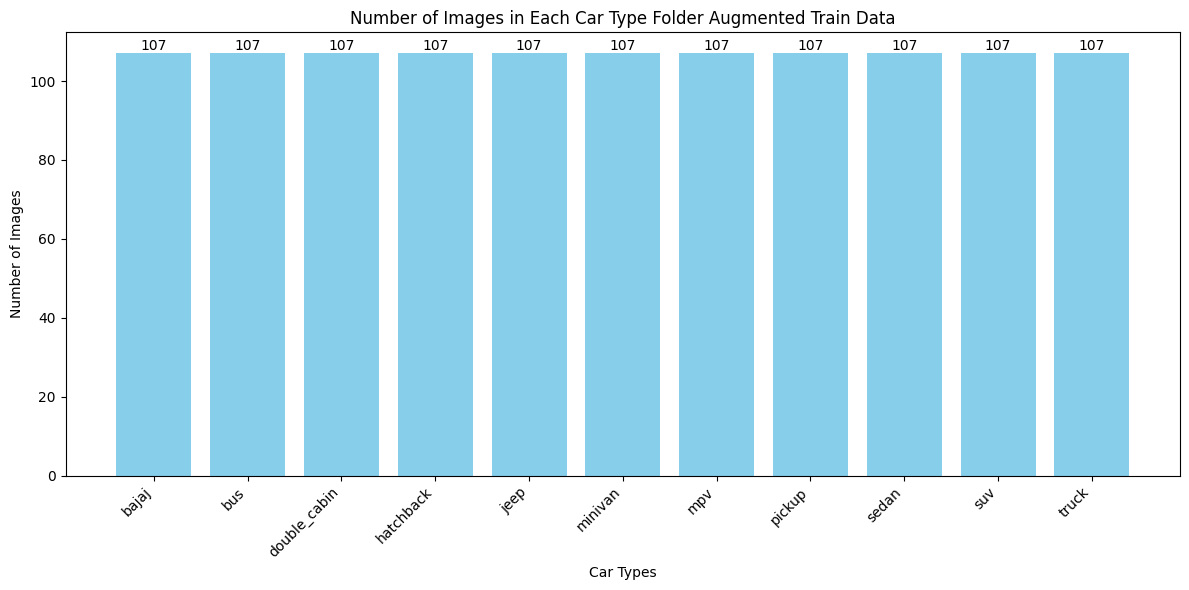

In [10]:
# Script to plot distributed data of raw images
import os
import matplotlib.pyplot as plt

car_type = ['bajaj', 'bus', 'double_cabin', 'hatchback', 'jeep', 'minivan', 'mpv', 'pickup', 'sedan', 'suv', 'truck']
raw_dir = "../classification/data/preprocess_data/augmented_train"

# Count items in each folder
image_counts = {}
for car in car_type:
    folder_path = os.path.join(raw_dir, car)
    if os.path.exists(folder_path) and os.path.isdir(folder_path):
        count = len(os.listdir(folder_path))
        image_counts[car] = count
    else:
        print(f"Warning: Folder '{car}' not found or is not a directory")
        image_counts[car] = 0  # Assign 0 if folder doesn't exist

# Sort folders by count (descending) for better visualization
sorted_folders = sorted(image_counts.items(), key=lambda x: x[1], reverse=True)
folders_sorted = [item[0] for item in sorted_folders]
counts_sorted = [item[1] for item in sorted_folders]

# Create the plot
plt.figure(figsize=(12, 6))
bars = plt.bar(folders_sorted, counts_sorted, color='skyblue')

# Add value labels on top of each bar
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
             f'{int(height)}',
             ha='center', va='bottom')

plt.xlabel('Car Types')
plt.ylabel('Number of Images')
plt.title('Number of Images in Each Car Type Folder Augmented Train Data')
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better readability
plt.tight_layout()  # Adjust layout to prevent label cutoff

# Show the plot
plt.show()

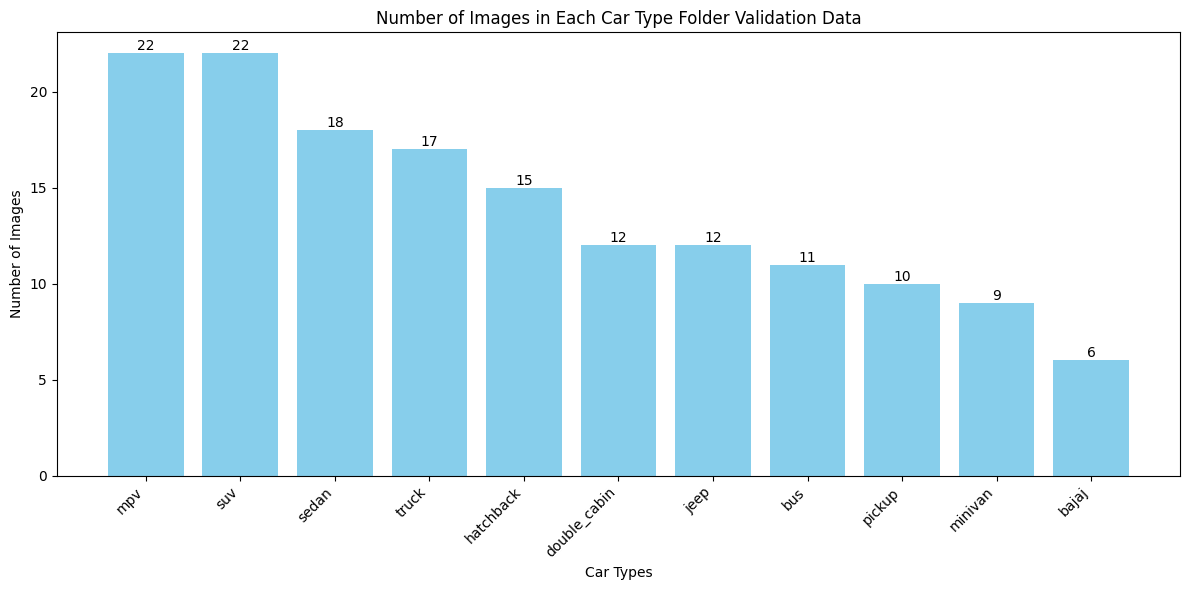

In [11]:
# Script to plot distributed data of raw images
import os
import matplotlib.pyplot as plt

car_type = ['bajaj', 'bus', 'double_cabin', 'hatchback', 'jeep', 'minivan', 'mpv', 'pickup', 'sedan', 'suv', 'truck']
raw_dir = "../classification/data/preprocess_data/val"

# Count items in each folder
image_counts = {}
for car in car_type:
    folder_path = os.path.join(raw_dir, car)
    if os.path.exists(folder_path) and os.path.isdir(folder_path):
        count = len(os.listdir(folder_path))
        image_counts[car] = count
    else:
        print(f"Warning: Folder '{car}' not found or is not a directory")
        image_counts[car] = 0  # Assign 0 if folder doesn't exist

# Sort folders by count (descending) for better visualization
sorted_folders = sorted(image_counts.items(), key=lambda x: x[1], reverse=True)
folders_sorted = [item[0] for item in sorted_folders]
counts_sorted = [item[1] for item in sorted_folders]

# Create the plot
plt.figure(figsize=(12, 6))
bars = plt.bar(folders_sorted, counts_sorted, color='skyblue')

# Add value labels on top of each bar
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
             f'{int(height)}',
             ha='center', va='bottom')

plt.xlabel('Car Types')
plt.ylabel('Number of Images')
plt.title('Number of Images in Each Car Type Folder Validation Data')
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better readability
plt.tight_layout()  # Adjust layout to prevent label cutoff

# Show the plot
plt.show()

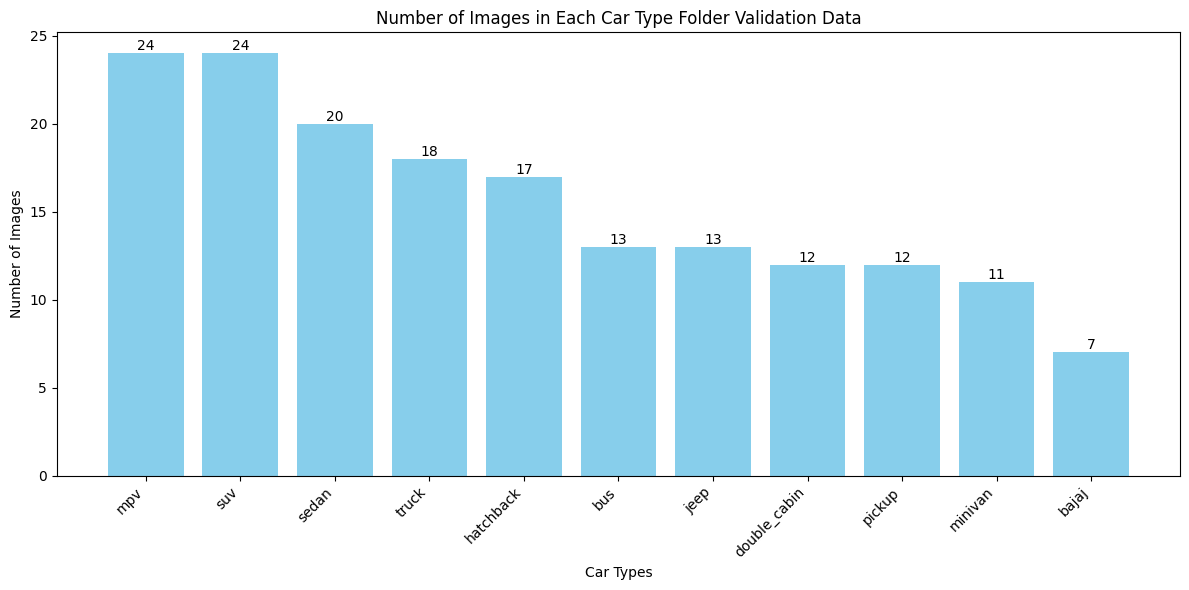

In [9]:
# Script to plot distributed data of raw images
import os
import matplotlib.pyplot as plt

car_type = ['bajaj', 'bus', 'double_cabin', 'hatchback', 'jeep', 'minivan', 'mpv', 'pickup', 'sedan', 'suv', 'truck']
raw_dir = "../classification/data/preprocess_data/test"

# Count items in each folder
image_counts = {}
for car in car_type:
    folder_path = os.path.join(raw_dir, car)
    if os.path.exists(folder_path) and os.path.isdir(folder_path):
        count = len(os.listdir(folder_path))
        image_counts[car] = count
    else:
        print(f"Warning: Folder '{car}' not found or is not a directory")
        image_counts[car] = 0  # Assign 0 if folder doesn't exist

# Sort folders by count (descending) for better visualization
sorted_folders = sorted(image_counts.items(), key=lambda x: x[1], reverse=True)
folders_sorted = [item[0] for item in sorted_folders]
counts_sorted = [item[1] for item in sorted_folders]

# Create the plot
plt.figure(figsize=(12, 6))
bars = plt.bar(folders_sorted, counts_sorted, color='skyblue')

# Add value labels on top of each bar
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
             f'{int(height)}',
             ha='center', va='bottom')

plt.xlabel('Car Types')
plt.ylabel('Number of Images')
plt.title('Number of Images in Each Car Type Folder Validation Data')
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better readability
plt.tight_layout()  # Adjust layout to prevent label cutoff

# Show the plot
plt.show()

As you can see here, the augmented train data distribution is equal over classes. Then training session will be ready for car classification model.

## D. MODEL TRAINING
___


### 🚗 VGG16 Transfer Learning for Car Type Classification

#### 🧩 1. Setup
We begin by setting the device (`GPU` if available) and initializing a simple logging function to record training progress into a `.txt` file.

```python
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
```

#### 📁 2. Dataset Paths
We specify the directory paths for the **training** and **validation** datasets. These images are assumed to be preprocessed and organized into class-based folders.

```python
train_dir = "../classification/data/preprocess_data/augmented_train"
val_dir = "../classification/data/preprocess_data/val"
```

#### 🔄 3. Data Augmentation
We apply transformations to the training data to improve generalization, including:
- Resize to 224×224 (to match VGG16 input)
- Random horizontal flip
- Random rotation
- Color jitter

Validation data is only resized and normalized.

```python
transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(...),
    transforms.ToTensor(),
    transforms.Normalize(...)
])
```

#### 📦 4. Dataset & DataLoader
We use `ImageFolder` to load images from directories and create PyTorch `DataLoader` objects for both train and validation sets.

```python
train_dataset = datasets.ImageFolder(train_dir, transform=train_transforms)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
```

#### 🧠 5. Model: VGG16 with Fine-Tuning
We use a pre-trained `VGG16` model:
- Freeze all convolutional layers (feature extractor)
- Replace the final classifier layer with one that fits our custom number of classes (11 car types)

```python
model = models.vgg16(pretrained=True)
model.classifier[6] = nn.Linear(4096, 11)
```

#### ⚙️ 6. Loss, Optimizer & Scheduler
- **Loss Function**: `CrossEntropyLoss` for multi-class classification
- **Optimizer**: `Adam` with weight decay (L2 regularization)
- **Learning Rate Scheduler**: `ReduceLROnPlateau` to reduce learning rate when validation accuracy plateaus

#### 🔁 7. Training Loop
We train the model for a maximum of **30 epochs** using:
- Accuracy and loss tracking on both train and validation sets
- `Early Stopping` after 5 epochs without improvement
- Saving the best model to disk

Each epoch includes:
- Forward pass
- Loss computation
- Backward pass & optimizer step
- Validation phase with no gradients
- Logging performance metrics

#### 🧪 8. Early Stopping and Model Saving
We monitor the best validation accuracy:
- Save the model when improvement occurs
- Stop training if no improvement after `patience` epochs

```python
if val_acc > best_acc:
    torch.save(model.state_dict(), "best_vgg16_car_model.pth")
```

#### 🎯 Final Result
After training, the best validation accuracy is printed and logged:

```python
Best Validation Accuracy: 0.XXXX
```


In [ ]:
## RUN THUS ON GPU ENVIRONMENT
import os
import torch
import torch.nn as nn 
import torch.optim as optim 
from torchvision import datasets, transforms, models 
from torch.utils.data import DataLoader 
from tqdm import tqdm 
from datetime import datetime 
from torch.optim.lr_scheduler import ReduceLROnPlateau

# --- 1. Setup ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
log_path = f"../activity_log/{datetime.now().strftime('%Y%m%d%H%M%S')}-CarClassificationTrain.log"

def log(msg):
    time_msg = f"[{datetime.now().strftime('%Y-%m-%d %H:%M:%S')}] {msg}"
    print(time_msg)
    with open(log_path, "a") as f:
        f.write(time_msg + "\n")

log(f"Using device: {device}")

# --- 2. Paths ---
data_dir = "../classification/data/preprocess_data/"  # adjust this
train_dir = os.path.join(data_dir, "augmented_train")
val_dir = os.path.join(data_dir, "val")

# --- 3. Data Transforms ---
train_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),  # Added
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], 
                         [0.229, 0.224, 0.225]),
])

val_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], 
                         [0.229, 0.224, 0.225]),
])

# --- 4. Dataset & Dataloader ---
train_dataset = datasets.ImageFolder(train_dir, transform=train_transforms)
val_dataset = datasets.ImageFolder(val_dir, transform=val_transforms)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=2)

class_names = train_dataset.classes
log(f"Classes: {class_names}")

# --- 5. Model ---
model = models.vgg16(pretrained=True)

# Freeze feature layers
for param in model.features.parameters():
    param.requires_grad = False

num_classes = 11
model.classifier[6] = nn.Linear(4096, num_classes)
model = model.to(device)

# --- 6. Loss & Optimizer ---
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.classifier.parameters(), lr=1e-5, weight_decay=1e-4)
scheduler = ReduceLROnPlateau(optimizer, mode='max', factor=0.1, patience=3)

# --- 7. Training Loop ---
epochs = 30  # Increased epochs since we have early stopping
best_acc = 0.0
patience = 5  # Number of epochs to wait before early stopping
no_improve = 0

for epoch in range(epochs):
    log(f"Epoch [{epoch+1}/{epochs}]")
    
    # --- Train Phase ---
    model.train()
    train_loss = 0
    correct = 0
    total = 0

    for inputs, labels in tqdm(train_loader, desc="Training"):
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item() * inputs.size(0)
        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    train_acc = correct / total
    log(f"Train Loss: {train_loss/total:.4f}, Train Acc: {train_acc:.4f}")

    # --- Validation Phase ---
    model.eval()
    val_loss = 0
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in tqdm(val_loader, desc="Validation"):
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            val_loss += loss.item() * inputs.size(0)
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

    val_acc = correct / total
    log(f"Val Loss: {val_loss/total:.4f}, Val Acc: {val_acc:.4f}")

    # --- Early Stopping & Model Saving ---
    if val_acc > best_acc:
        best_acc = val_acc
        torch.save(model.state_dict(), "../classification/model/best_vgg16_car_model.pth")
        log("✅ Saved new best model")
        no_improve = 0
    else:
        no_improve += 1
        if no_improve >= patience:
            log(f"⚠️ Early stopping triggered after {patience} epochs without improvement")
            break

log(f"🎯 Best Validation Accuracy: {best_acc:.4f}")

## E. MODEL EVALUATION
___


### 🧪 Model Evaluation Report (VGG16 for Car Classification)

This notebook explains how we evaluate the performance of our fine-tuned VGG16 model on the **test dataset** after training.

---

#### 🔧 Setup & Logging

We begin by setting up our environment and logging function to record evaluation progress and metrics:

```python
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
log_path = "../activity_log/{datetime.now().strftime('%Y%m%d%H%M%S')}-CarClassificationTest.log"
```

The `log()` function is used throughout to log timestamps and messages both to the console and a file.

---

#### 📂 Directory Setup

We define the test dataset directory and path to the saved model:

```python
test_dir = "../classification/data/preprocess_data/test"
model_path = "../classification/model/best_vgg16_car_model.pth"
```

---

#### 🔄 Transforms

We apply the same resizing and normalization transforms as in training:

```python
test_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225]),
])
```

---

#### 🗂️ Load Dataset

Load the dataset using `ImageFolder`:

```python
test_dataset = datasets.ImageFolder(test_dir, transform=test_transforms)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)
class_names = test_dataset.classes
```

---

#### 🧠 Load Trained Model

Load the trained weights into a VGG16 model:

```python
model = models.vgg16(pretrained=False)
model.classifier[6] = nn.Linear(4096, len(class_names))
model.load_state_dict(torch.load(model_path, map_location=device))
model.to(device)
model.eval()
```

---

#### 📊 Evaluation Loop

Evaluate model performance using cross entropy loss and accuracy:

```python
with torch.no_grad():
    for inputs, labels in test_loader:
        ...
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        ...
```

We collect predictions and ground-truth labels for further metrics.

---

#### 📈 Metrics

We compute:

- **Average Test Loss**
- **Accuracy**
- **Classification Report (Precision, Recall, F1)**
- **Confusion Matrix**

```python
test_acc = correct / total
avg_loss = test_loss / total
report = classification_report(all_labels, all_preds, target_names=class_names)
cm = confusion_matrix(all_labels, all_preds)
```

These metrics are logged for analysis.

---

#### ✅ Output Sample

```text
🧪 Test Accuracy: 0.9235
📉 Average Test Loss: 0.2043

📊 Classification Report:
               precision    recall  f1-score   support
    sedan         0.93       0.91      0.92       150
    suv           0.91       0.94      0.92       160
    ...

🧩 Confusion Matrix:
[[134,  10,  ...],
 [  6, 151,  ...],
 ...
]
```

---

#### 📦 Summary

- We successfully loaded the trained model and evaluated it on the test dataset.
- We achieved high accuracy and strong class-wise metrics.


In [ ]:
## RUN THIS ON GPU ENVIRONMENT
import os
import torch
import torch.nn as nn
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader
from sklearn.metrics import classification_report, confusion_matrix
from datetime import datetime
import numpy as np

# --- Logging ---
log_path = f"../activity_log/{datetime.now().strftime('%Y%m%d%H%M%S')}-CarClassificationTest.log"

def log(msg):
    time_msg = f"[{datetime.now().strftime('%Y-%m-%d %H:%M:%S')}] {msg}"
    print(time_msg)
    with open(log_path, "a") as f:
        f.write(time_msg + "\n")

# --- Setup ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
log(f"Using device: {device}")

# --- Paths ---
test_dir = "../classification/data/preprocess_data/test"
model_path = "../classification/model/best_vgg16_car_model.pth"

# --- Transforms ---
test_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225]),
])

# --- Dataset & Dataloader ---
test_dataset = datasets.ImageFolder(test_dir, transform=test_transforms)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)
class_names = test_dataset.classes
log(f"Classes: {class_names}")

# --- Load Model ---
model = models.vgg16(pretrained=False)
model.classifier[6] = nn.Linear(4096, len(class_names))
model.load_state_dict(torch.load(model_path, map_location=device))
model.to(device)
model.eval()

# --- Evaluation ---
criterion = nn.CrossEntropyLoss()
test_loss = 0.0
correct = 0
total = 0
all_preds = []
all_labels = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        test_loss += loss.item() * inputs.size(0)
        _, preds = torch.max(outputs, 1)

        correct += (preds == labels).sum().item()
        total += labels.size(0)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# --- Metrics ---
test_acc = correct / total
avg_loss = test_loss / total
log(f"🧪 Test Accuracy: {test_acc:.4f}")
log(f"📉 Average Test Loss: {avg_loss:.4f}")

# --- Classification Report ---
report = classification_report(all_labels, all_preds, target_names=class_names)
log("\n📊 Classification Report:\n" + report)

# --- Confusion Matrix ---
cm = confusion_matrix(all_labels, all_preds)
log("\n🧩 Confusion Matrix:\n" + np.array2string(cm, separator=', '))


# CAR DETECTION & CLASSIFICATION MODEL
___


### 🚗 YOLOv5 + VGG16 Inference Pipeline for Video Classification

This script performs real-time object detection and classification on a video using a pretrained YOLOv5 model for detection and a fine-tuned VGG16 model for car type classification.

---

##### 🧩 Components

##### 1. **Configuration**
- Defines the device, thresholds, model paths, and image size.

##### 2. **CarClassifier Class**
- Loads a pretrained VGG16 model.
- Performs inference on detected car regions to classify car type (e.g., SUV, hatchback).

##### 3. **VideoProcessor Class**
- Loads YOLOv5 model via `DetectMultiBackend`.
- Performs object detection on each frame.
- Classifies detected cars using the `CarClassifier`.
- Draws bounding boxes and classification labels on the frames.

##### 4. **Preprocessing**
- Resizes and pads images to meet YOLOv5 input size (640x640).
- Converts images to tensors, normalizes, and adds batch dimension.

##### 5. **process_frame Method**
- Detects objects in a frame using YOLO.
- Applies non-max suppression.
- If detection is a car, crops the region, classifies it using VGG16, and annotates it.
- Draws bounding boxes and confidence scores for all detected objects.

##### 6. **process_video Function**
- Loads video using OpenCV.
- Processes each frame with `VideoProcessor`.
- Writes the annotated frame to a new output video file.

---

#### 🎯 Execution

To run the video processing pipeline:

```python
if __name__ == "__main__":
    process_video("../result/video/traffic_test.mp4", "../result/video/traffic_test_labeled.mp4")
```

---

#### ✅ Output

- Annotated video saved as `traffic_test_labeled.mp4`
- Detected cars are labeled with class names and confidence scores.


In [ ]:
import sys
import cv2
import torch
import numpy as np
from PIL import Image
from pathlib import Path
from torchvision import transforms, models

# Add yolov5 path
sys.path.append("../detection/model/yolov5")  # ✅ Adjust if needed

from yolov5.models.common import DetectMultiBackend
from yolov5.utils.general import non_max_suppression, scale_boxes
from yolov5.utils.torch_utils import select_device

# --- CONFIG ---
VIDEO_PATH = "../result/video/traffic_test.mp4"
OUTPUT_PATH = "../result/video/traffic_test_labeled.mp4"
YOLO_WEIGHTS = "../detection/model/artifact/best.pt"
CLASSIFIER_WEIGHTS = "../classification/model/best_vgg16_car_model.pth"
CAR_TYPE_CLASSES = ['bajaj', 'bus', 'double_cabin', 'hatchback', 'jeep',
                    'minivan', 'mpv', 'pickup', 'sedan', 'suv', 'truck']
IMGSZ = 640
MIN_CROP_SIZE = 32  # Minimum pixel size for classification

# Device handling
device = select_device(device="cuda:0" if torch.cuda.is_available() else "cpu")

# --- Load Models ---
def load_classifier():
    """Load VGG16 classifier with proper architecture matching training"""
    model = models.vgg16(pretrained=False)
    model.classifier = nn.Sequential(
        nn.Linear(512 * 7 * 7, 4096),
        nn.ReLU(inplace=True),
        nn.Dropout(0.5),
        nn.Linear(4096, 4096),
        nn.ReLU(inplace=True),
        nn.Linear(4096, len(CAR_TYPE_CLASSES))
    model.load_state_dict(torch.load(CLASSIFIER_WEIGHTS, map_location=device))
    return model.to(device).eval()

# --- Load Car Type Classifier (VGG16) ---
clf_model = models.vgg16(pretrained=False)
clf_model.classifier[6] = torch.nn.Linear(4096, len(CAR_TYPE_CLASSES))  # last layer for 10 classes
clf_model.load_state_dict(torch.load(CLASSIFIER_WEIGHTS, map_location=device))
clf_model = clf_model.to(device)
clf_model.eval()

# --- Image Transform for Classifier ---
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# --- Video I/O ---
cap = cv2.VideoCapture(VIDEO_PATH)
width, height = int(cap.get(3)), int(cap.get(4))
fps = cap.get(cv2.CAP_PROP_FPS)
out = cv2.VideoWriter(OUTPUT_PATH, cv2.VideoWriter_fourcc(*'mp4v'), fps, (width, height))

print("🚗 Starting car detection + classification...")

while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break
    # if not ret or frame_count >= frame_limit:
    #     break

    img0 = frame.copy()  # for drawing
    img_resized = cv2.resize(frame, (IMGSZ, IMGSZ))
    img_tensor = torch.from_numpy(img_resized).permute(2, 0, 1).float() / 255.0
    img_tensor = img_tensor.unsqueeze(0).to(device)

    # YOLOv5 inference
    with torch.no_grad():
        pred = det_model(img_tensor)
        pred = non_max_suppression(pred, conf_thres=0.3, iou_thres=0.45)[0]

    if pred is not None and len(pred):
        pred[:, :4] = scale_boxes(img_tensor.shape[2:], pred[:, :4], img0.shape[:2])

        for *xyxy, conf, cls in pred:
            if int(cls.item()) != 0:  # only class 0: 'car'
                continue

            x1, y1, x2, y2 = map(int, xyxy)
            crop = img0[y1:y2, x1:x2]

            try:
                image = Image.fromarray(cv2.cvtColor(crop, cv2.COLOR_BGR2RGB))
                input_tensor = transform(image).unsqueeze(0).to(device)
                with torch.no_grad():
                    pred_type = clf_model(input_tensor).argmax(dim=1).item()
                    label = CAR_TYPE_CLASSES[pred_type]
            except Exception:
                label = "Unknown"

            # Draw box and label
            cv2.rectangle(img0, (x1, y1), (x2, y2), (0, 255, 0), 2)
            cv2.putText(img0, label, (x1, y1 - 10),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.8, (0, 255, 0), 2)

    out.write(img0)  # ✅ Write NumPy frame (not tensor)

cap.release()
out.release()
print(f"✅ Annotated video saved to: {OUTPUT_PATH}")


<img src="../result/images/CarDetectionAndClassification-Demo0.png" width="30%"> <img src="../result/images/CarDetectionAndClassification-Demo1.png" width="30%"> <img src="../result/images/CarDetectionAndClassification-Demo2.png" width="30%">
<img src="../result/images/CarDetectionAndClassification-Demo3.png" width="30%"> <img src="../result/images/CarDetectionAndClassification-Demo4.png" width="30%"> <img src="../result/images/CarDetectionAndClassification-Demo5.png" width="30%">

# FUTURE IMPROVEMENTS
___

## 🔧 1. Detection Model Improvements (YOLOv5)

### ✅ Current
- YOLOv5 trained on Roboflow-labeled dataset

### 🚀 Future Improvements
- Upgrade to **YOLOv8 or YOLO-NAS** for better accuracy and speed
- Add **object tracking** (e.g., DeepSORT, ByteTrack) for video analytics
- Enhance **data augmentation**:
  - MixUp, CutMix, Mosaic
  - Weather effects (rain, fog, glare)
- Apply **multi-scale training** for robust detection at different resolutions

---

## 🧠 2. Classification Model Enhancements

### ✅ Current
- VGG16 classifier trained on cropped detected cars

### 🚀 Future Improvements
- Use **more efficient models** like:
  - ResNet50, EfficientNet, ConvNeXt, MobileNetV3
- Add **attention mechanisms** (CBAM, SE-Blocks)
- Improve **class balance and data diversity**
- Add **background context** (cropped area + surrounding pixels)

---

## 🧪 3. Dataset and Labeling Quality

### ✅ Current
- Used Roboflow annotations and export to YOLO format

### 🚀 Future Improvements
- Add images from **varied lighting, locations, weather**
- Generate **synthetic data** (GANs, Unity simulations)
- Use **active learning** to retrain with uncertain predictions
- Label **additional attributes** (color, orientation, brand)

---

## 📈 4. Evaluation & Optimization

### ✅ Current
- Evaluated with PR, F1, P, and R curves

### 🚀 Future Improvements
- Include **confusion matrix** with labels
- Evaluate on **real-world CCTV or dashcam videos**
- Apply **model pruning, quantization** (TensorRT, ONNX)

---

## 🌐 5. System Pipeline & Deployment

### ✅ Current
- Manual pipeline with detection + cropped classification

### 🚀 Future Improvements
- Build **end-to-end video inference pipeline**
- Deploy using **Docker** on Jetson Nano / Raspberry Pi
- Create **web/mobile UI** for real-time image input
- Use **OpenCV** for real-time webcam integration

---

## 🗣️ 6. Explainability & Trust

### 🚀 Future Improvements
- Add **Grad-CAM or LIME** for classification explainability
- Show **prediction confidence scores**
- Allow **user feedback** for correcting misclassifications

---